# **Import Libraries**

In [22]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
from keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

# **Upload Train and Test Images**

In [23]:
# Install Kaggle library in Colab

# !pip install kaggle
# Requirement already satisfied

# Move Kaggle API token to the appropriate directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Set appropriate permissions for the Kaggle API token
!chmod 600 ~/.kaggle/kaggle.json
# Download the dataset using Kaggle API
!kaggle datasets download -d aadityasinghal/facial-expression-dataset
# Unzip the downloaded file
!unzip /content/facial-expression-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/train/sad/Training_65242339.jpg  
  inflating: train/train/sad/Training_65267116.jpg  
  inflating: train/train/sad/Training_65275626.jpg  
  inflating: train/train/sad/Training_6529266.jpg  
  inflating: train/train/sad/Training_65329617.jpg  
  inflating: train/train/sad/Training_65338712.jpg  
  inflating: train/train/sad/Training_65338797.jpg  
  inflating: train/train/sad/Training_65387162.jpg  
  inflating: train/train/sad/Training_65404494.jpg  
  inflating: train/train/sad/Training_65426218.jpg  
  inflating: train/train/sad/Training_65430136.jpg  
  inflating: train/train/sad/Training_65437377.jpg  
  inflating: train/train/sad/Training_6545735.jpg  
  inflating: train/train/sad/Training_65463385.jpg  
  inflating: train/train/sad/Training_65473985.jpg  
  inflating: train/train/sad/Training_65502829.jpg  
  inflating: train/train/sad/Training_65505359.jpg  
  inflating: train/train/sad/Training_65508578.jpg

# **Initialize train and test directories**

In [24]:
TRAIN_DIR = '/content/train/train/'
TEST_DIR = '/content/test/test/'

# **Define function to load image paths with coresponding labels from images directory**

In [25]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels

# **Create data frame for training data**

In [26]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

surprise Completed
disgust Completed
neutral Completed
sad Completed
happy Completed
fear Completed
angry Completed


,image,label
0,/content/train/train/angry/Training_95645186.jpg,angry
1,/content/train/train/surprise/Training_870398.jpg,surprise
2,/content/train/train/happy/Training_31543797.jpg,happy
3,/content/train/train/fear/Training_73845317.jpg,fear
4,/content/train/train/happy/Training_6287501.jpg,happy


# **Create data frame for testing data**

In [27]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

surprise Completed
disgust Completed
neutral Completed
sad Completed
happy Completed
fear Completed
angry Completed


,image,label
0,/content/test/test/surprise/PrivateTest_637600...,surprise
1,/content/test/test/surprise/PublicTest_4639501...,surprise
2,/content/test/test/surprise/PublicTest_6842363...,surprise
3,/content/test/test/surprise/PublicTest_8323183...,surprise
4,/content/test/test/surprise/PublicTest_7431524...,surprise


# **Exploratory Data Analysis**

<ipython-input-28-770861a4f374>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train['label'] , palette='bright')


<Axes: xlabel='label', ylabel='count'>

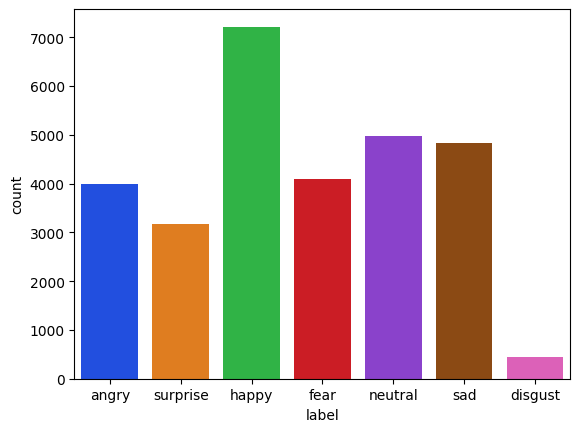

In [28]:
sns.countplot(x=train['label'] , palette='bright')

# **Show sample image**

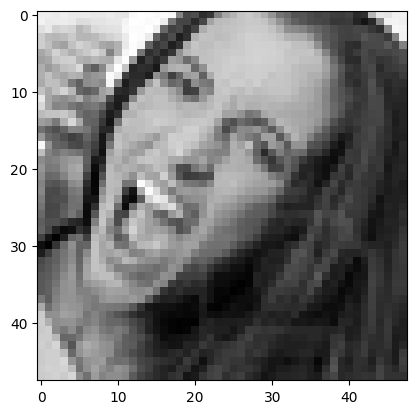

In [29]:
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

# **Display grid of images**

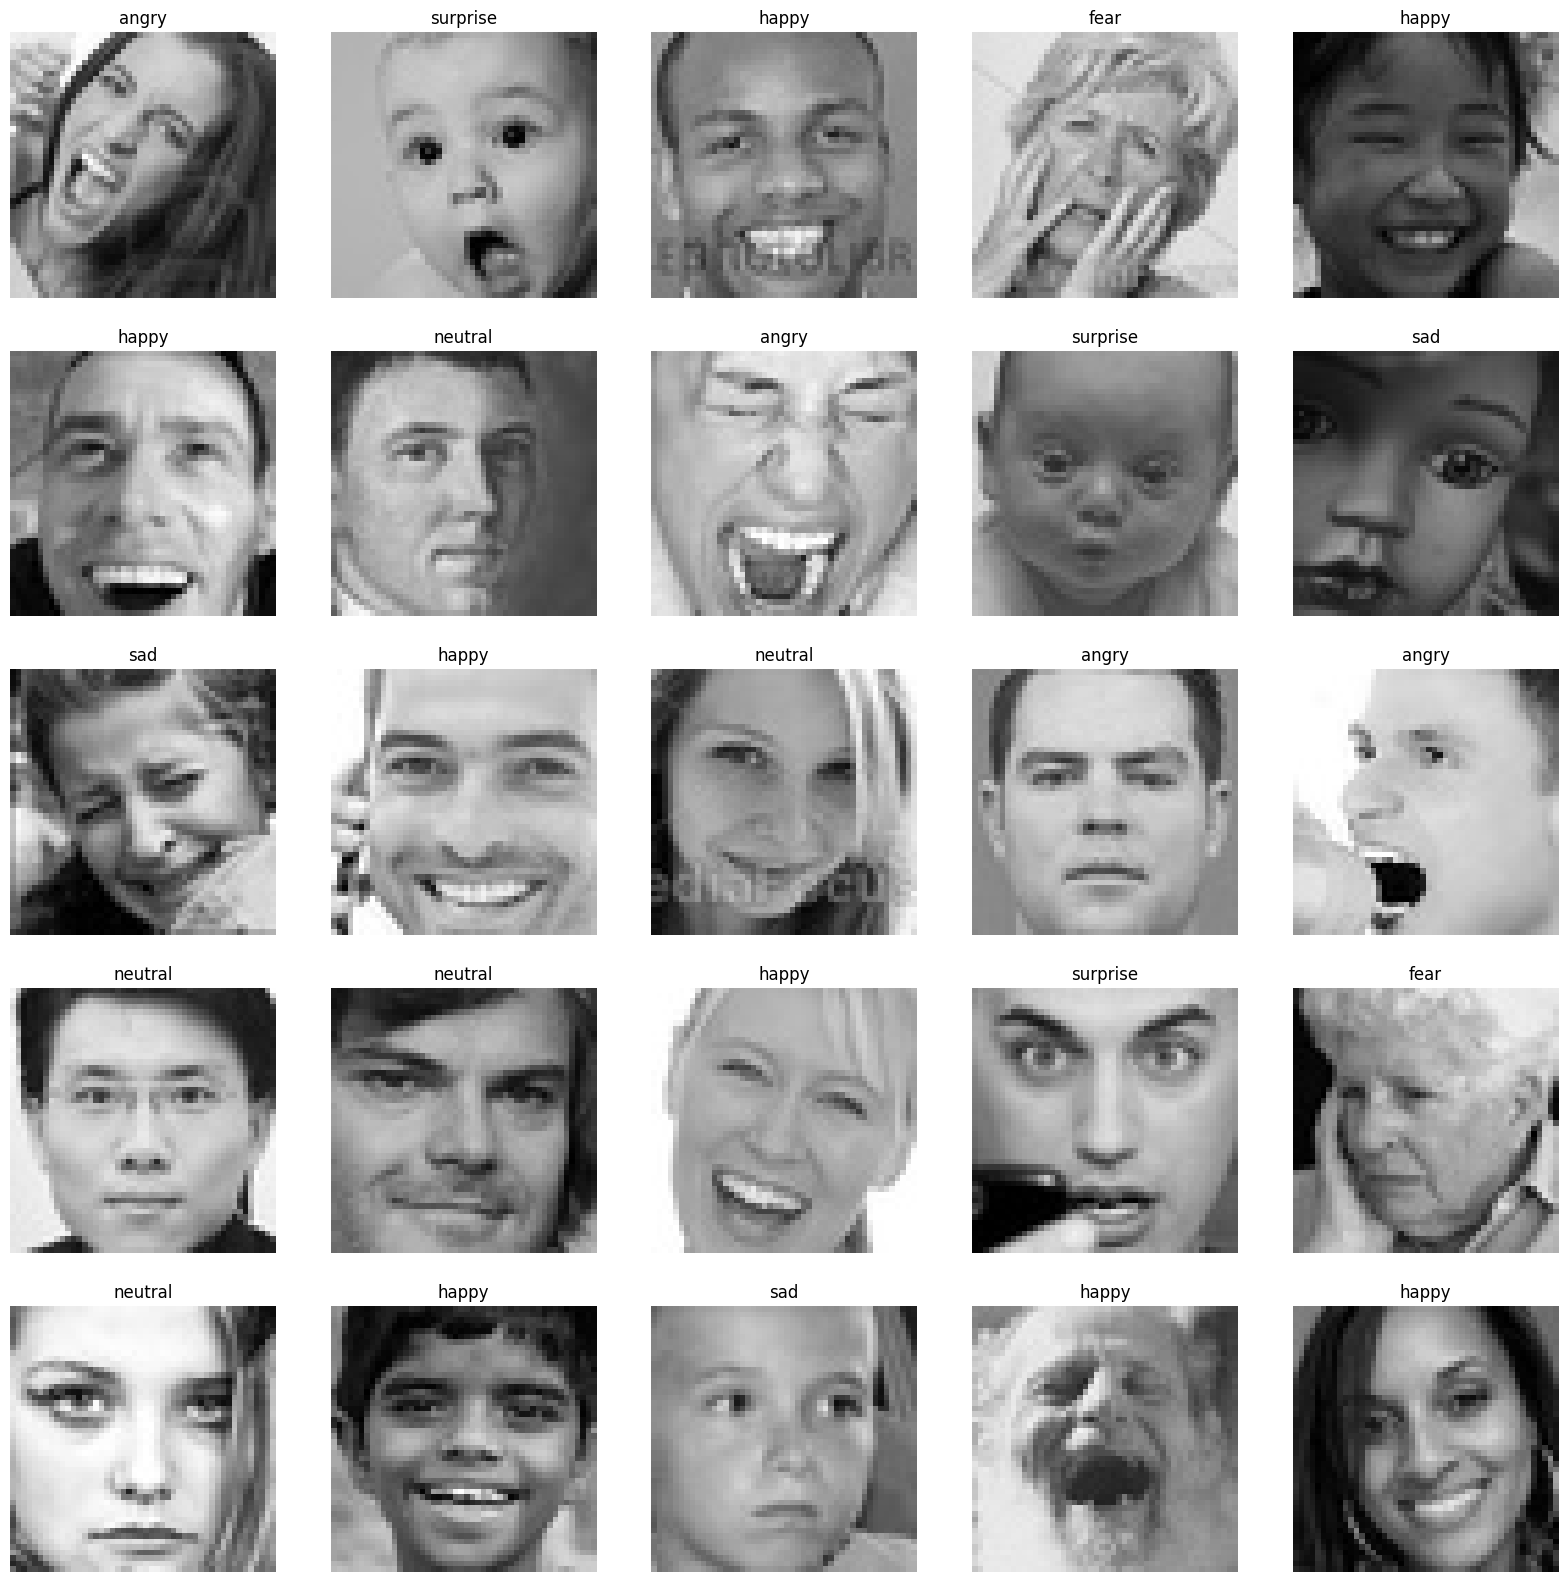

In [30]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

# **Extract the features**

In [31]:
def extract_features(images):
    features = []
    for image in images:
        img = load_img(image, color_mode="grayscale")
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [32]:
train_features = extract_features(train['image'])

In [33]:
test_features = extract_features(test['image'])

# **Normalizing the Image Data, Converting integer values to floating point values**

In [34]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

# **Categorically Encoding the Labels**

In [35]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [36]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [37]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [38]:
# config
input_shape = (48, 48, 1)
output_class = 7

# **Creating the Model**

In [39]:
# Model Creation


model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(1024, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))


# **Summarize the model**

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 128)       1280      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 23, 23, 128)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 23, 23, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 10, 10, 256)       0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 10, 10, 256)      

# **Compile the model**

In [41]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

# **Train the model**

In [42]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
225/225 [==============================] - 23s 68ms/step - loss: 1.8242 - accuracy: 0.2444 - val_loss: 1.8109 - val_accuracy: 0.2471
Epoch 2/100
225/225 [==============================] - 12s 55ms/step - loss: 1.7695 - accuracy: 0.2662 - val_loss: 1.6806 - val_accuracy: 0.3178
Epoch 3/100
225/225 [==============================] - 13s 57ms/step - loss: 1.6194 - accuracy: 0.3576 - val_loss: 1.4671 - val_accuracy: 0.4401
Epoch 4/100
225/225 [==============================] - 13s 57ms/step - loss: 1.4891 - accuracy: 0.4203 - val_loss: 1.3741 - val_accuracy: 0.4628
Epoch 5/100
225/225 [==============================] - 12s 54ms/step - loss: 1.4156 - accuracy: 0.4526 - val_loss: 1.3264 - val_accuracy: 0.4857
Epoch 6/100
225/225 [==============================] - 13s 56ms/step - loss: 1.3710 - accuracy: 0.4739 - val_loss: 1.2991 - val_accuracy: 0.5022
Epoch 7/100
225/225 [==============================] - 12s 55ms/step - loss: 1.3417 - accuracy: 0.4832 - val_loss: 1.2727 - val_ac

# **Saving the model to an H5 File**

In [43]:
model.save("model.h5")
model.save_weights("weights.h5")
print("Model saved to disk.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to disk.


# **Loading the model from an H5 File**

In [44]:
# Load the model from the H5 file
loaded_model = load_model("model.h5")
# Load model weights into the new model
loaded_model.load_weights("weights.h5")
print("Model loaded from disk.")

Model loaded from disk.


# **Detect emotion type from image**

Original Output: happy
1/1 [==============================] - 0s 52ms/step
Predicted Output: happy


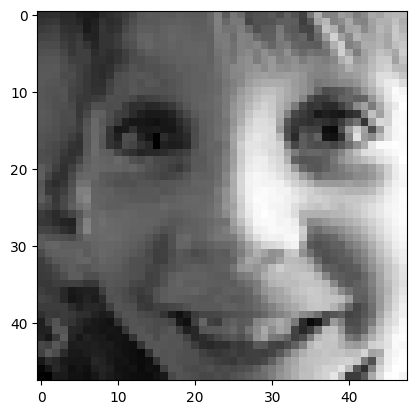

In [49]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])

# pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
pred = loaded_model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)

plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');